In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install matplotlib --quiet

In [ ]:
!pip install hmmlearn --quiet

In [ ]:
# Import libraries for data manipulation and analysis
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
# Read datafile
data = pd.read_csv('/content/drive/MyDrive/PTDLKD/Data/Gold_Data.csv')
data=data.set_index(pd.DatetimeIndex(data['Date'].values))

# Preprocessing

---



In [ ]:
# Flip the column
data = data.iloc[::-1]

# Format column Date
data.Date = pd.to_datetime(data.Date,format='%m/%d/%Y')

# Drop column that aren't use
data.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis = 1, inplace=True)

# Format column Price to float
data['Price'] = data.Price.str.replace(',','').astype(float)

# Spilt Dataset (7-2-1)

---



In [ ]:
# Just use the Price
df = data

Price_7_2_1 = df['Price'].values.reshape(-1, 1)

split_1_3 = 1/3

# Split the data into training, testing, and validation sets
train_data, temp_data = train_test_split(Price_7_2_1, test_size=0.3, random_state=42) # tran: 70%Data, temp: 30%Data
test_data, validate_data = train_test_split(temp_data, test_size=split_1_3, random_state=42) # test: 2/3temp, val: 1/3temp

train_size = len(train_data)
test_size = len(test_data)
val_size = len(validate_data)

# Create and train HMM model with training set
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Predict hidden state for train, test set
hidden_states_train = model.predict(train_data)
hidden_states_test = model.predict(test_data)
hidden_states_val = model.predict(validate_data)

In [ ]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

prices_last_30 = df1['Price'].values.reshape(-1, 1)

predicted_states = model.predict(prices_last_30[-30:])
predicted_prices = [model.means_[int(state)][0] for state in predicted_states]
print(predicted_prices)

[1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994, 1822.5868331007994]


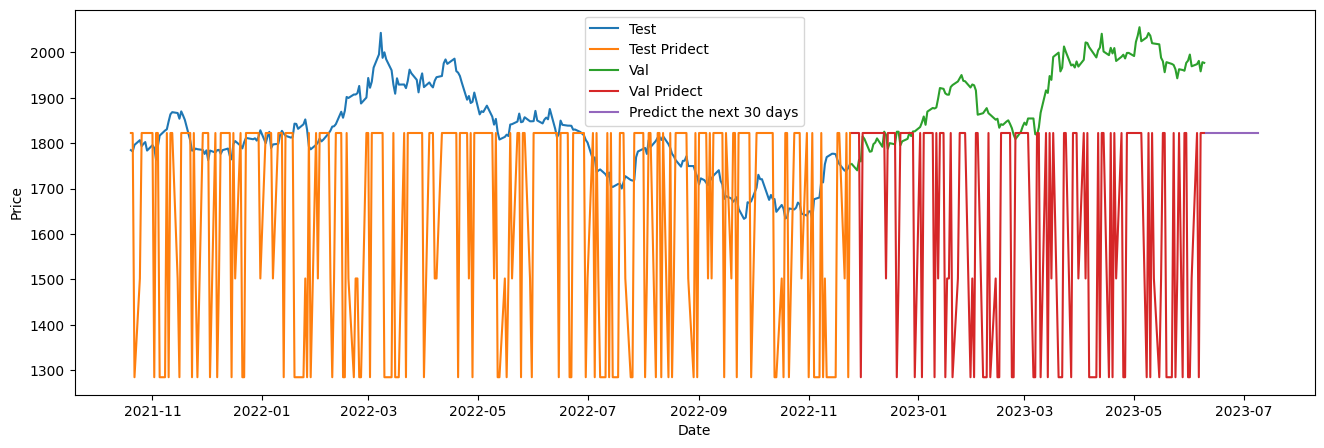

In [ ]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, [model.means_[state][0] for state in hidden_states_test], label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, [model.means_[state][0] for state in hidden_states_val], label='Val Pridect')
plt.plot(df1.index[-30:], predicted_prices, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
# # Calculate accuracy for each model
rmse = np.sqrt(mean_squared_error(test_data, [model.means_[state][0] for state in hidden_states_test]))
mape = mean_absolute_percentage_error(test_data, [model.means_[state][0] for state in hidden_states_test]) * 100
mae = mean_absolute_error(test_data, [model.means_[state][0] for state in hidden_states_test])

print("** Test **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(validate_data, [model.means_[state][0] for state in hidden_states_val]))
mape = mean_absolute_percentage_error(validate_data, [model.means_[state][0] for state in hidden_states_val]) * 100
mae = mean_absolute_error(validate_data, [model.means_[state][0] for state in hidden_states_val])

print("** Validate **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

** Test **
RMSE: 76.96537733549424
MAPE: 3.4849318325393277
MAE: 58.74186724229117
** Validate **
RMSE: 85.19073689585204
MAPE: 4.011658980085076
MAE: 66.0121820519529


In [ ]:
#########################################

In [ ]:
train_states = pd.unique(hidden_states_train)
print("Train states:",train_states)

test_states = pd.unique(hidden_states_test)
print("Test states:",test_states)

val_states = pd.unique(hidden_states_val)
print("val states:",val_states)

Train states: [2 1 0]
Test states: [2 1 0]
val states: [2 1 0]


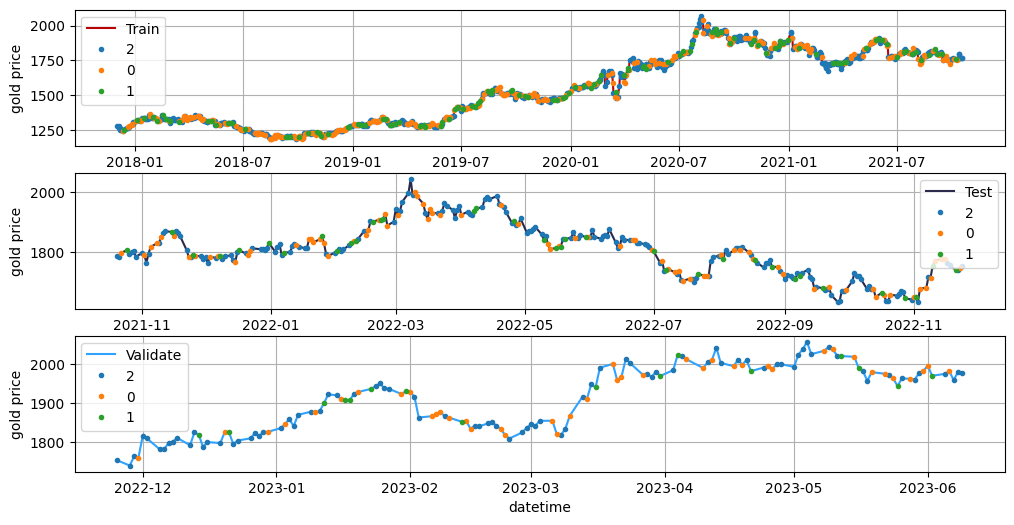

In [ ]:
train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(train_data.Date, train_data.Price, '-', color="#B70404")
for i in train_states:
    want = (hidden_states_train == i)
    x = train_data.Date.iloc[want]
    y = train_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Train",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")

plt.subplot(3,1,2)
plt.plot(test_data.Date, test_data.Price, '-', color="#2B2A4C", label='Test')
for i in test_states:
    want = (hidden_states_test == i)
    x = test_data.Date.iloc[want]
    y = test_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Test",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")

plt.subplot(3,1,3)
plt.plot(val_data.Date, val_data.Price, '-', color="#30A2FF", label='Validate')
for i in val_states:
    want = (hidden_states_val == i)
    x = val_data.Date.iloc[want]
    y = val_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Validate",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")
plt.show()

# Spilt Dataset (6-3-1)

---



In [ ]:
# Just use the Price
df = data

Price_7_2_1 = df['Price'].values.reshape(-1, 1)

split_1_4 = 0.25

# Split the data into training, testing, and validation sets
train_data, temp_data = train_test_split(Price_7_2_1, test_size=0.4, random_state=42) # tran: 60%Data, temp: 40%Data
test_data, validate_data = train_test_split(temp_data, test_size=split_1_4, random_state=42) # test: 3/4temp, val: 1/4temp

train_size = len(train_data)
test_size = len(test_data)
val_size = len(validate_data)

# Create and train HMM model with training set
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Predict hidden state for train, test set
hidden_states_train = model.predict(train_data)
hidden_states_test = model.predict(test_data)
hidden_states_val = model.predict(validate_data)

In [ ]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

prices_last_30 = df1['Price'].values.reshape(-1, 1)

predicted_states = model.predict(prices_last_30[-30:])
predicted_prices = [model.means_[int(state)][0] for state in predicted_states]
print(predicted_prices)

[1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925, 1778.4536409532925]


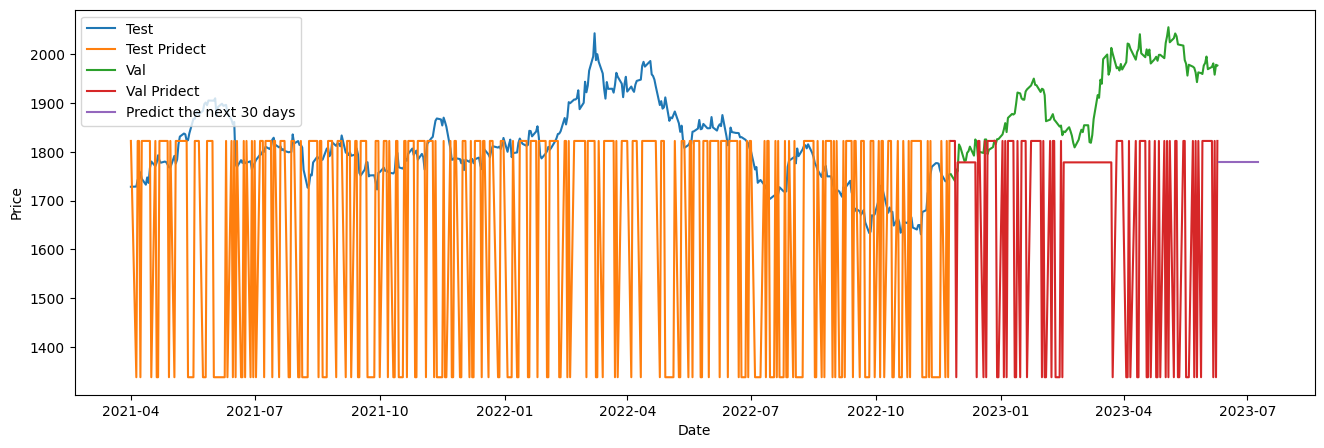

In [ ]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, [model.means_[state][0] for state in hidden_states_test], label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, [model.means_[state][0] for state in hidden_states_val], label='Val Pridect')
plt.plot(df1.index[-30:], predicted_prices, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
# # Calculate accuracy for each model
rmse = np.sqrt(mean_squared_error(test_data, [model.means_[state][0] for state in hidden_states_test]))
mape = mean_absolute_percentage_error(test_data, [model.means_[state][0] for state in hidden_states_test]) * 100
mae = mean_absolute_error(test_data, [model.means_[state][0] for state in hidden_states_test])

print("** Test **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(validate_data, [model.means_[state][0] for state in hidden_states_val]))
mape = mean_absolute_percentage_error(validate_data, [model.means_[state][0] for state in hidden_states_val]) * 100
mae = mean_absolute_error(validate_data, [model.means_[state][0] for state in hidden_states_val])

print("** Validate **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

** Test **
RMSE: 104.12758019201064
MAPE: 5.03820960941322
MAE: 80.76544594861718
** Validate **
RMSE: 122.9994703657127
MAPE: 5.926799636671989
MAE: 93.6127192418591


In [ ]:
#########################################3

In [ ]:
train_states = pd.unique(hidden_states_train)
print("Train states:",train_states)

test_states = pd.unique(hidden_states_test)
print("Test states:",test_states)

val_states = pd.unique(hidden_states_val)
print("val states:",val_states)

Train states: [2 1 0]
Test states: [2 1]
val states: [2 1 0]


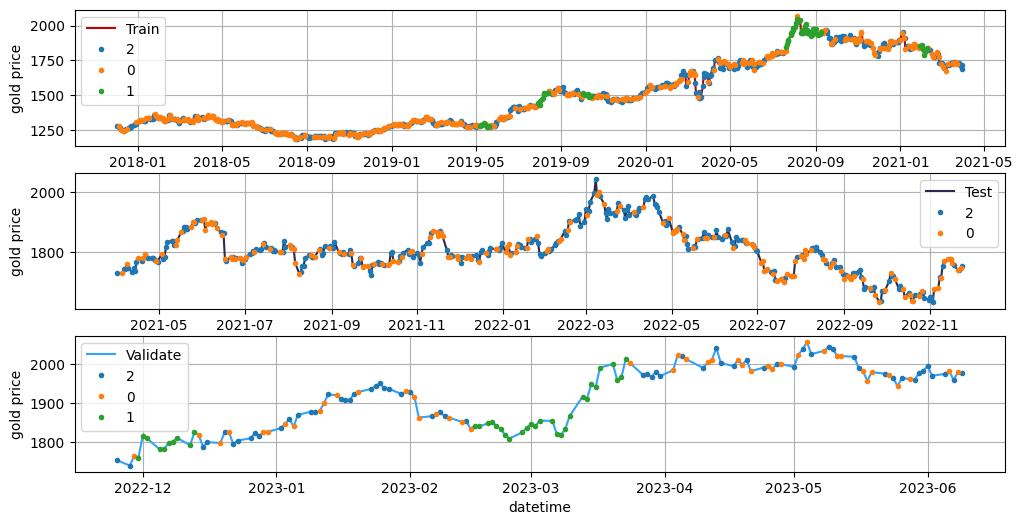

In [ ]:
train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(train_data.Date, train_data.Price, '-', color="#B70404")
for i in train_states:
    want = (hidden_states_train == i)
    x = train_data.Date.iloc[want]
    y = train_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Train",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")

plt.subplot(3,1,2)
plt.plot(test_data.Date, test_data.Price, '-', color="#2B2A4C", label='Test')
for i in test_states:
    want = (hidden_states_test == i)
    x = test_data.Date.iloc[want]
    y = test_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Test",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")

plt.subplot(3,1,3)
plt.plot(val_data.Date, val_data.Price, '-', color="#30A2FF", label='Validate')
for i in val_states:
    want = (hidden_states_val == i)
    x = val_data.Date.iloc[want]
    y = val_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Validate",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")
plt.show()

# Spilt Dataset (5-3-2)

---



In [ ]:
# Just use the Price
df = data

Price_7_2_1 = df['Price'].values.reshape(-1, 1)

split_1_3 = 1/3

# Split the data into training, testing, and validation sets
train_data, temp_data = train_test_split(Price_7_2_1, test_size=0.5, random_state=42) # tran: 50%Data, temp: 50%Data
test_data, validate_data = train_test_split(temp_data, test_size=split_1_3, random_state=42) # test: 3/5temp, val: 2/5temp

train_size = len(train_data)
test_size = len(test_data)
val_size = len(validate_data)

# Create and train HMM model with training set
model = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
model.fit(train_data)

# Predict hidden state for train, test set
hidden_states_train = model.predict(train_data)
hidden_states_test = model.predict(test_data)
hidden_states_val = model.predict(validate_data)

In [ ]:
# Predict 30 days
new_index = pd.date_range(start=df.index[-1], periods=31, freq='D')[1:]
df1 = df.reindex(df.index.union(new_index))

df1.fillna(0, inplace=True)

prices_last_30 = df1['Price'].values.reshape(-1, 1)

predicted_states = model.predict(prices_last_30[-30:])
predicted_prices = [model.means_[int(state)][0] for state in predicted_states]
print(predicted_prices)

[1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794, 1744.8154392085794]


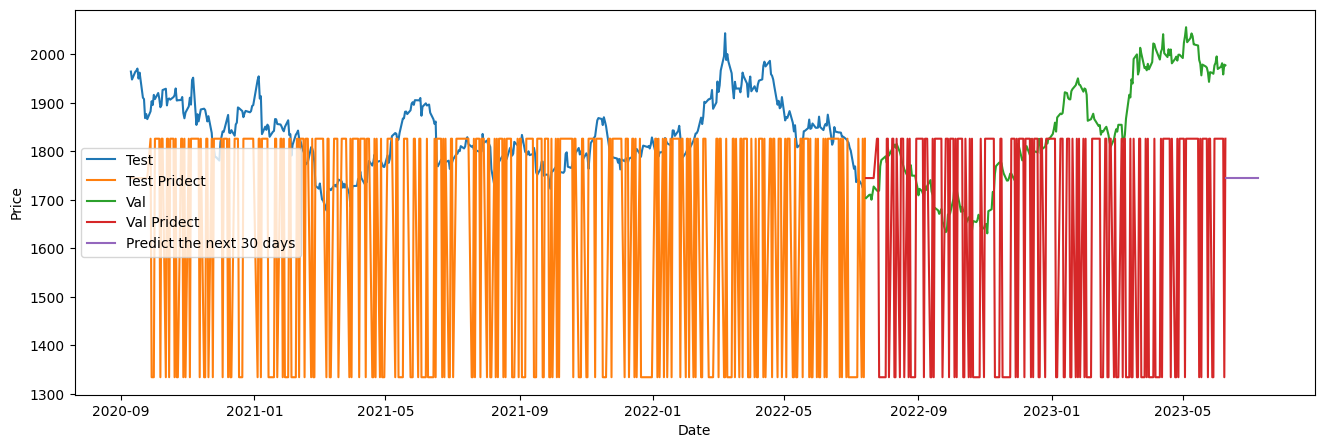

In [ ]:
train = df[:train_size]
test = df[train_size:train_size+test_size]
validate = df[train_size+test_size:]

# Plot the model
plt.figure(figsize=(16,5))

plt.plot(test.index, test.Price, label='Test')
plt.plot(test.index, [model.means_[state][0] for state in hidden_states_test], label='Test Pridect')
plt.plot(validate.index, validate.Price, label='Val')
plt.plot(validate.index, [model.means_[state][0] for state in hidden_states_val], label='Val Pridect')
plt.plot(df1.index[-30:], predicted_prices, label='Predict the next 30 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
# # Calculate accuracy for each model
rmse = np.sqrt(mean_squared_error(test_data, [model.means_[state][0] for state in hidden_states_test]))
mape = mean_absolute_percentage_error(test_data, [model.means_[state][0] for state in hidden_states_test]) * 100
mae = mean_absolute_error(test_data, [model.means_[state][0] for state in hidden_states_test])

print("** Test **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

rmse = np.sqrt(mean_squared_error(validate_data, [model.means_[state][0] for state in hidden_states_val]))
mape = mean_absolute_percentage_error(validate_data, [model.means_[state][0] for state in hidden_states_val]) * 100
mae = mean_absolute_error(validate_data, [model.means_[state][0] for state in hidden_states_val])

print("** Validate **")
print("RMSE:", rmse)
print("MAPE:", mape)
print("MAE:", mae)

** Test **
RMSE: 101.36763681913759
MAPE: 5.010467377374549
MAE: 80.31996083957414
** Validate **
RMSE: 101.78552046734701
MAPE: 5.0098626045388714
MAE: 80.16374841017574


In [ ]:
#########################################3

In [ ]:
train_states = pd.unique(hidden_states_train)
print("Train states:",train_states)

test_states = pd.unique(hidden_states_test)
print("Test states:",test_states)

val_states = pd.unique(hidden_states_val)
print("val states:",val_states)

Train states: [2 1 0]
Test states: [2 1 0]
val states: [2 1 0]


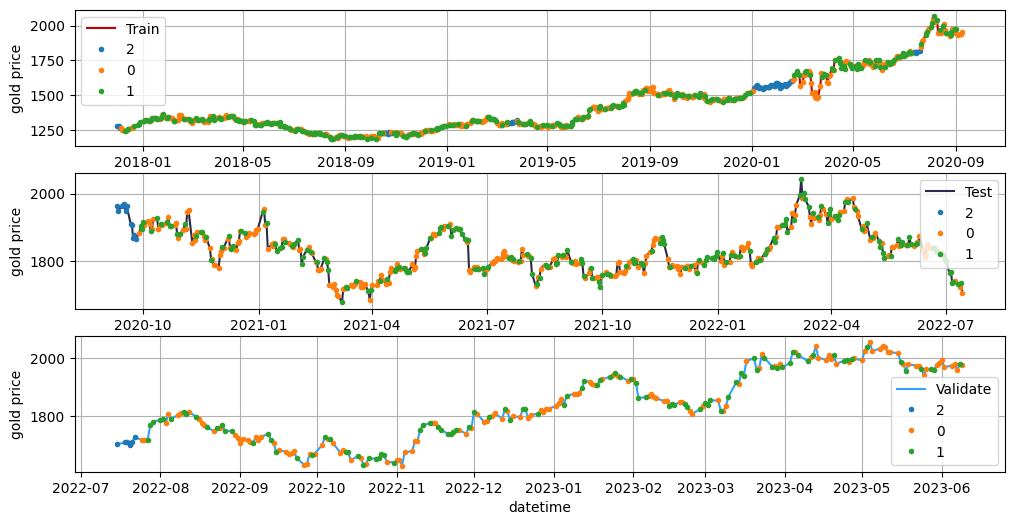

In [ ]:
train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

plt.figure(figsize=(12, 6))
plt.subplot(3,1,1)
plt.plot(train_data.Date, train_data.Price, '-', color="#B70404")
for i in train_states:
    want = (hidden_states_train == i)
    x = train_data.Date.iloc[want]
    y = train_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Train",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")

plt.subplot(3,1,2)
plt.plot(test_data.Date, test_data.Price, '-', color="#2B2A4C", label='Test')
for i in test_states:
    want = (hidden_states_test == i)
    x = test_data.Date.iloc[want]
    y = test_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Test",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")

plt.subplot(3,1,3)
plt.plot(val_data.Date, val_data.Price, '-', color="#30A2FF", label='Validate')
for i in val_states:
    want = (hidden_states_val == i)
    x = val_data.Date.iloc[want]
    y = val_data.Price.iloc[want]
    plt.plot(x, y, '.')
plt.legend(["Validate",2,0,1])
plt.grid(True)
plt.xlabel("datetime")
plt.ylabel("gold price")
plt.show()

# Evaluating model

---

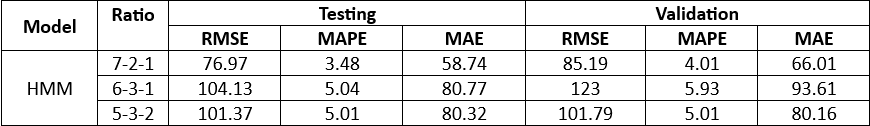